In [1]:
from hpsklearn import any_classifier, any_preprocessing, standard_scaler, min_max_scaler, HyperoptEstimator
from hyperopt import tpe

from sklearn import metrics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
x_train = np.load('x_train.npy', allow_pickle=True)
x_test = np.load('x_test.npy', allow_pickle=True)

y_train = np.load('y_train.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

columns = ['img_file', 'sub']

ch = ['{}-CH{}'.format(band, i+1) for band in ['alpha', 'beta', 'gamma'] for i in range(64)]
ch.append('RT')
columns.extend(ch)

df_train = pd.DataFrame(np.hstack((x_train, y_train[..., np.newaxis])), columns=columns)
df_test = pd.DataFrame(np.hstack((x_test, y_test[..., np.newaxis])), columns=columns)

x_train = x_train[:, 2:194].astype(np.float64)
x_test = x_test[:, 2:194].astype(np.float64)

df_train.head()

,img_file,sub,alpha-CH1,alpha-CH2,alpha-CH3,alpha-CH4,alpha-CH5,alpha-CH6,alpha-CH7,alpha-CH8,...,gamma-CH56,gamma-CH57,gamma-CH58,gamma-CH59,gamma-CH60,gamma-CH61,gamma-CH62,gamma-CH63,gamma-CH64,RT
0,bts_36830.png,S12-epo,0.6372152282053747,0.539538551169332,0.5152014963248736,0.5858683663578949,0.35902010578575744,0.5044245216962114,0.5063204377512986,0.483179041799244,...,0.0011094395393581376,0.0012414736822082063,0.0011654319436241178,0.001268028204608622,0.0014874405785328148,0.001387590928976121,0.0013716017472919042,0.0014240997848051393,0.0013516430491567067,3
1,bts_55432.png,S8-epo,0.08334234813210595,0.10449727967402468,0.060650446470157736,0.08629934997645246,0.06653130692033934,0.0236550733664704,0.03134650112373549,0.06893467919670168,...,0.0006518066234724544,0.0006172818126063925,0.0005584346256347597,0.0005451261687997133,0.0008549529115127927,0.0006961723728019211,0.0007838507845397537,0.000760238295074771,0.0008625412530374178,1
2,bts_28166.png,N9-epo,0.0231311815058243,0.012152922056323009,0.014736804248881508,0.018908965959176353,0.005693844154533352,0.06358613309822281,0.03625190288510876,0.011674786289937265,...,0.00012498106545776183,0.00013141044430450897,0.00021423434904080377,0.00023786449446414312,0.0003406674633213204,0.0002773240266327603,0.00016099429554909713,0.00017798496564264935,0.000162878997054303,1
3,bts_106897.png,T9-epo,0.07781710445328677,0.08308750348941416,0.09159634576526983,0.08333503135697722,0.1084353814502676,0.06258658408605956,0.06308558680384876,0.07566827235576194,...,0.003498623332093341,0.00555201510036608,0.005691748402312867,0.004387270074565077,0.0027020632318464997,0.0034989548589954506,0.011216350050824091,0.025722604790699835,0.0031410152673831877,3
4,bts_76139.png,S18-epo,0.03486573742772753,0.007789287053270632,0.013015885193082962,0.021835449461000904,0.011075410142438853,0.01840523969217402,0.029117449741784936,0.021084248366279635,...,0.00029000050332931546,0.00036061540278607235,0.0004275228929360573,0.0005870999577384255,0.00028771744905186107,0.0002734073316357683,0.0003152501771324686,0.0004522571411244008,0.00035482888808227163,0


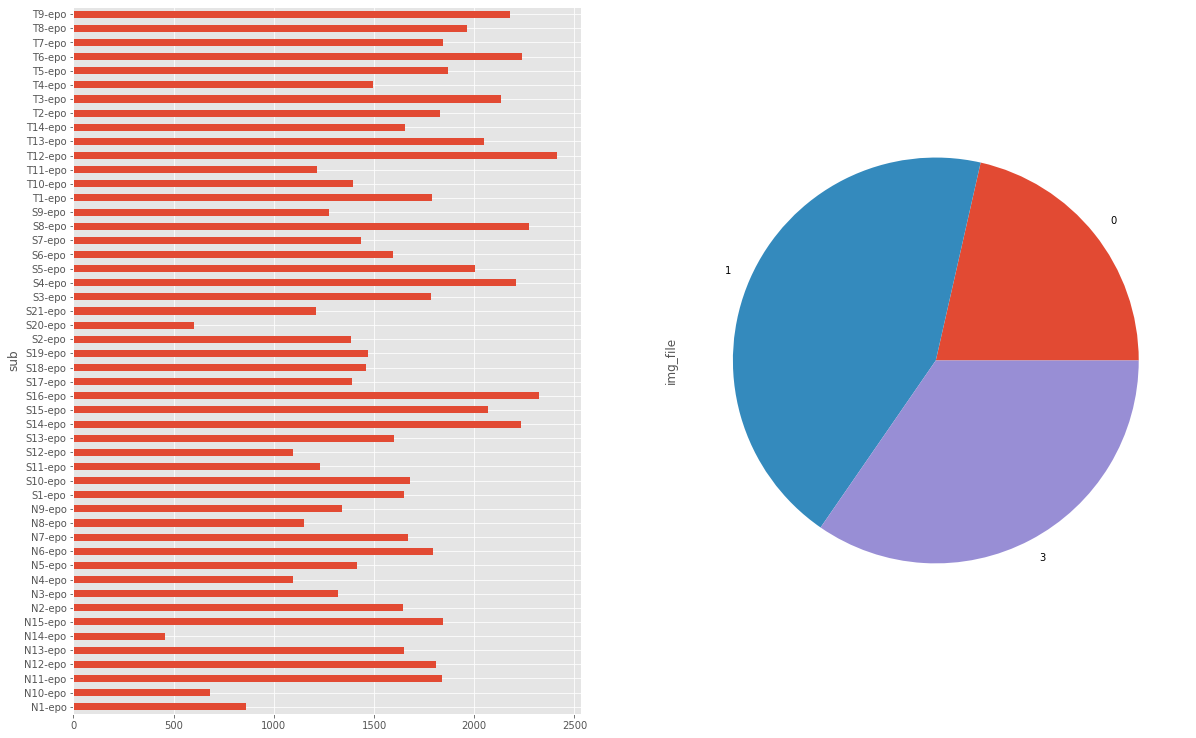

In [3]:
count_by_sub_ex = df_train.groupby('sub').count()['img_file']
count_by_sub_ex.columns = ['sub', 'count']

count_by_RT_ex = df_train.groupby('RT').count()['img_file']
count_by_RT_ex.columns = ['RT', 'count']

plt.figure(figsize=(20,13))
plt.subplot(121)

count_by_sub_ex.plot.barh(x='count', y='sub')

plt.subplot(122)

count_by_RT_ex.plot.pie(x='RT', y='count')

In [4]:
estim = HyperoptEstimator(classifier=any_classifier('my_clf'), 
                              preprocessing=any_preprocessing('my_pre'),
                             algo=tpe.suggest,
                             max_evals=100,
                             trial_timeout=120)

estim.fit(x_train, y_train)

# Show the results

print(estim.score(x_test, y_test))
# 1.0

print(estim.best_model())

100%|██████████| 100/100 [00:49<00:00,  2.04trial/s, best loss: 0.25948896055569337]
0.7470598604850286
{'learner': ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None,
                     max_features=0.9690702434563587, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=102, n_jobs=1, oob_score=False,
                     random_state=0, verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}


In [6]:
# preproc = estim.best_model()['preprocs'][0]

model = estim.best_model()['learner']

# X_test = preproc.transform(x_test)

y_pred = model.predict(x_test)

              precision    recall  f1-score   support

           0       0.83      0.66      0.73      8494
           1       0.74      0.86      0.80     17495
           3       0.71      0.65      0.68     13720

    accuracy                           0.75     39709
   macro avg       0.76      0.73      0.74     39709
weighted avg       0.75      0.75      0.74     39709



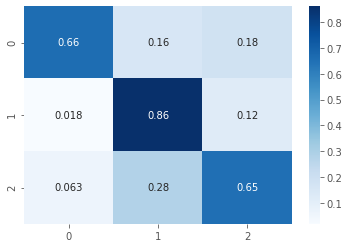

In [8]:
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(metrics.confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True)

In [63]:
np.unique(y_pred)

array([0, 1, 3])